In [1]:
# Importing needed libraries

import torch, os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from helpers import *
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from CGDs import ACGD

c:\Users\dange\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Impossibile trovare la procedura specificata
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(Generator, self).__init__()
        self.input_dim = input_dim 
        self.output_dim = output_dim 
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        # The following layers are used to upsample the input
        # noise and generate an output image.
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        # This function initializes the weights and biases of the 
        # generator's layers:
        initialize_weights(self) 

    def forward(self, input):
        '''
        The input to the forward method represents the input noise 
        to the generator model. It returns the generated output image.
        '''
        
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4)) # Reshapes x to match the expected size for the subsequent transposed convolutional layers. 
        x = self.deconv(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        
        # This function initializes the weights and biases of the 
        # discriminator's layers:
        initialize_weights(self)

    def forward(self, input):
        '''
        The input to the forward method represents the input image
        It returns the output prediction, which represents the discriminator's assessment of the input image.
        '''
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [4]:
class WGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        self.epoch = epoch
        self.batch_size = batch_size

        self.save_dir = save_dir
        self.result_dir = result_dir

        self.device = device
        self.dataset = dataset

        self.input_size = input_size    # Default: 32

        self.D_losses = []
        self.G_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.model_name = 'WGAN'        
        self.z_dim = 62                 # Represents the dimensionality of the (Gaussian) random input vector used by the generator.
        self.d_param_max = 0.01         # Clipping value
        self.iteration_g_per_d = 5      # Specifies the number of iterations of the generator per discriminator iteration. 
                                        # This controls the relative training frequency of the generator and discriminator.

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)        
        
        if self.dataset == 'cifar10':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialize generator, discriminator and optimizers
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()

        print('---------------INITIALIZATION-----------------')
        print('|           Model: WGAN with Adam            |')
        print('----------------------------------------------')


    def train(self):
        self.y_real = torch.ones(self.batch_size, 1) # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1) # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train() #D network in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            iteration_losses_G = []     # Auxiliary arrays to compute the mean loss for each epoch
            iteration_losses_D = []

            self.G.train() #G network in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == (self.data_loader.dataset.__len__() // self.batch_size): # Exit the loop when it has been used the whole dataset
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train) # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real) # Calculates the loss for the discriminator on real data. 
                                                  # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise) # Generates fake data using the generator
                D_fake = self.D(G_) # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake) # Calculates the loss for the discriminator on fake data. 
                                                 # The objective is to minimize the average output of the discriminator for fake data.

                D_loss = D_real_loss + D_fake_loss # Calculates the total discriminator loss as the sum of the losses on real and fake data.

                D_loss.backward()
                self.D_optimizer.step()

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake) # Calculates the generator loss as the negative average output of the discriminator for fake data. 
                                                 # The objective is to maximize the average output of the discriminator for the generated fake data.

                    iteration_losses_G.append(G_loss.item())

                    G_loss.backward()

                    self.G_optimizer.step()

                    iteration_losses_D.append(D_loss.item())
                
                if tot_iter % 1000 == 0:        # Compute the Inception scores and the FID scores every 1000 iterations
                     with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1
            
            self.G_losses.append(np.mean(iteration_losses_G))
            self.D_losses.append(np.mean(iteration_losses_D))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Discriminator loss: {self.D_losses[-1]}')
            print(f'Generator loss: {self.G_losses[-1]}')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")
        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.G_losses, self.save_dir, self.dataset, self.model_name, Generator=True)
        save_loss(self.D_losses, self.save_dir, self.dataset, self.model_name, Discriminator=True)
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
        


    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID



    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    


    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')
        


In [5]:
class WGAN_GP(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2):
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_size = input_size

        self.dataset = dataset

        self.save_dir = save_dir
        self.result_dir = result_dir

        self.device = device

        self.model_name = 'WGAN_GP'
        self.z_dim = 62
        self.lambda_ = 10
        self.iteration_g_per_d = 5

        
        self.G_losses = []
        self.D_losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []

        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)
        
        if self.dataset == 'cifar10':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])           
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)),
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                        transforms.Normalize(mean=(0.5), std=(0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
                
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()
        
        print('---------------INITIALIZATION-----------------')
        print('| Model: WGAN with Adam and Gradient Penalty |')
        print('----------------------------------------------')


    def train(self):    
        self.y_real = torch.ones(self.batch_size, 1)
        self.y_fake = torch.zeros(self.batch_size, 1)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake =  self.y_fake.cuda()

        self.D.train() #Discriminator in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            iteration_losses_G = []                                                  # Auxiliary arrays to compute the mean loss for each epoch
            iteration_losses_D = []
            
            self.G.train()                                                           # Generator in train mode

            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:    # Exit the loop when it has been used the whole dataset
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))
                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # PART 1: UPDATE THE DISCRIMINATOR
                self.D_optimizer.zero_grad()

                D_real = self.D(x_train)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_noise)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # Gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.device == 'cuda:0':
                    alpha = alpha.cuda()

                x_hat = alpha * x_train.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.device == 'cuda:0':
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty # Loss with gradient penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.iteration_g_per_d) == 0:
                    # PART 2: UPDATE THE GENERATOR
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_noise)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)

                    iteration_losses_G.append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    iteration_losses_D.append(D_loss.item())
                
                if tot_iter%1000 == 0:
                    with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1

            self.G_losses.append(np.mean(iteration_losses_G))
            self.D_losses.append(np.mean(iteration_losses_D))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average Discriminator loss: {self.D_losses[-1]}')
            print(f'Average Generator loss: {self.G_losses[-1]}\n')
            
            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished!")

        #self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.G_losses, self.D_losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.G_losses, self.save_dir, self.dataset, self.model_name, Generator=True)
        save_loss(self.D_losses, self.save_dir, self.dataset, self.model_name, Discriminator=True)
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS
    


    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID



    def visualize_results(self, epoch, fix=True):
        '''
        By calling this method during the training loop, you can visualize and save the 
        generated samples at regular intervals to monitor the progress 
        of the generator's output over the course of training.
        '''
        self.G.eval()                           # Set the generator in evaluation mode.

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)         # These samples represent the generator's output at the given epoch        
        
        # The dimensions are transposed to match the image format
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2             # Normalizes the samples by scaling their pixel 
                                                # values from the range [-1, 1] to the range [0, 1]
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')



    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')


In [6]:
class WGAN_ACGD(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD):
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_size = input_size

        self.dataset = dataset

        self.save_dir = save_dir
        self.result_dir = result_dir
        
        self.device = device

        self.model_name = 'WGAN_ACGD'
        self.z_dim = 62
        self.lambda_ = 10
        self.d_param_max = 0.01

        
        self.losses = []
        self.inception_scores = []
        self.frechet_inception_distances = []
        
        self.inception=InceptionScore(normalize=True)
        self.f=FrechetInceptionDistance(feature=64,normalize=True)               
        
        if self.dataset == 'cifar10':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        elif self.dataset == 'mnist':
                # Transformation to be applied on data in the DataLoader function
                transform = transforms.Compose([
                                        transforms.Resize((input_size, input_size)), 
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), 
                                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                        ])
                self.data_loader = DataLoader(
                    datasets.MNIST('data/mnist', train=True, download=True, transform=transform),
                    batch_size=batch_size, shuffle=True)
        
        data = self.data_loader.__iter__().__next__()[0]

        # Initialization of optimizers and of generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.optimizer = ACGD(max_params=self.G.parameters(), min_params=self.D.parameters(), lr_max=lrG, lr_min=lrD)
        

        if self.device == 'cuda:0':
            self.G.cuda()
            self.D.cuda()

        # Fixed noise: By setting up a fixed noise vector, the WGAN can generate consistent
        # samples from the generator over the course of training. This allows for visualizing
        # the progression of generated images or comparing them across different training iterations.
        self.sample_z = torch.rand((self.batch_size, self.z_dim))
        if self.device == 'cuda:0':
            self.sample_z = self.sample_z.cuda()

        print('----------------------INITIALIZATION------------------------')
        print('| Model: WGAN using Competitive Gradient Descent optimizer |')
        print('------------------------------------------------------------')
        

    def train(self):
        self.y_real = torch.ones(self.batch_size, 1)    # Initialize labels for real samples (i.e. 1)
        self.y_fake = torch.zeros(self.batch_size, 1)   # Initialize labels for fake samples (i.e. 0)

        if self.device == 'cuda:0':
            self.y_real = self.y_real.cuda()
            self.y_fake = self.y_fake.cuda()

        self.D.train()                                  #D network in train mode

        print('Start training!')
        tot_iter = 0
        for epoch in range(self.epoch):
            self.G.train()                              # G network in train mode
            iteration_losses = []                       # Auxilary array to compute the mean loss for each epoch
            for iter, (x_train, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_noise = torch.rand((self.batch_size, self.z_dim))

                if self.device == 'cuda:0':
                    x_train = x_train.cuda()
                    z_noise = z_noise.cuda()

                # UPDATE NETWORKS
                self.optimizer.zero_grad()

                D_real = self.D(x_train)                # Computes the discriminator output for real data
                D_real_loss = -torch.mean(D_real)       # Calculates the loss for the discriminator on real data. 
                                                        # The objective is to maximize the average output of the discriminator for real data.

                G_ = self.G(z_noise)                    # Generates fake data using the generator
                D_fake = self.D(G_)                     # Computes the discriminator output for fake data.
                D_fake_loss = torch.mean(D_fake)        # Calculates the loss for the discriminator on fake data. 
                                                        # The objective is to minimize the average output of the discriminator for fake data.

                loss = D_real_loss + D_fake_loss        # Calculates the total discriminator loss as the sum of the losses on real and fake data.
                
                iteration_losses.append(loss.detach().cpu())
                self.optimizer.step(loss=loss)

                # Clipping D parameters to a specified range to enforce Lipschitz continuity.
                for p in self.D.parameters():
                    p.data.clamp_(-self.d_param_max, self.d_param_max)
                
                if tot_iter%1000 == 0:
                    with torch.no_grad():
                        score=self.IS()
                        self.inception_scores.append(score[0].item())
                        distance=self.FID()
                        self.frechet_inception_distances.append(distance.item())
                tot_iter += 1

            self.losses.append(np.mean(iteration_losses))

            print(f'Epoch: {epoch+1}/{self.epoch}')
            print(f'Average loss: {self.losses[-1]}')

            with torch.no_grad():
                self.visualize_results((epoch+1))

        print("Training finished.")

        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot_ACGD(self.losses, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        save_scores(self.inception_scores, self.save_dir, self.dataset, self.model_name, IS=True)
        save_scores(self.frechet_inception_distances, self.save_dir, self.dataset, self.model_name, FID=True)
        save_loss(self.losses, self.save_dir, self.dataset, self.model_name)


    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        samples = self.G(self.sample_z)
        if self.device == 'cuda:0':
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples, [8, 8],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    


    def IS(self):
        self.G.eval()
        images = self.G(self.sample_z)
        self.inception.update(images.cpu())
        IS=self.inception.compute()   
        return IS



    def FID(self):
        self.G.eval()
        imagesG = self.G(self.sample_z)
        imagesR=self.data_loader.__iter__().__next__()[0]
        self.f.update(imagesR.cpu(), real=True)
        self.f.update(imagesG.cpu(), real=False)
        FID=self.f.compute()
        return FID
    

    def save_scores_loss(self):
        save_scores


    def print_networks(self):
        print('---------- Networks architecture -------------')
        print(self.G)
        print(self.D)
        print('-----------------------------------------------')

In [7]:
# PARAMETERS

# Define dataset ['cifar10', 'mnist']
dataset = 'mnist'

# Define WGAN type [WGAN, WGAN_GP, WGAN_ACGD]
gan_type = 'WGAN_GP'

# Define number of epoch
epoch = 100

# Define batch_size
batch_size = 64

# Define input_size
input_size = 32

# Define directory for saving results and models
save_dir = 'models'
result_dir = 'results'


# Defining learning rates
lrG = 0.0001        # Generator
lrD = 0.0001        # Discriminator

# Adam beta parameters
beta1 = 0.5
beta2 = 0.9

# 'cuda' if GPU is available, 'cpu' else
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

if gan_type == 'WGAN':
    wgan = WGAN(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_GP':
    wgan = WGAN_GP(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD, beta1, beta2)
elif gan_type == 'WGAN_ACGD':
    wgan = WGAN_ACGD(epoch, batch_size, save_dir, result_dir, dataset, device, input_size, lrG, lrD)


c:\Users\dange\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


---------------INITIALIZATION-----------------
| Model: WGAN with Adam and Gradient Penalty |
----------------------------------------------


Start training!
Epoch: 1/100
Average Discriminator loss: -1.937534692712168
Average Generator loss: 1.9557204134961501



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 2/100
Average Discriminator loss: -8.935974878423353
Average Generator loss: 9.821858163823418



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 3/100
Average Discriminator loss: -13.33379610337038
Average Generator loss: 23.012117253267828



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 4/100
Average Discriminator loss: -12.603857119453144
Average Generator loss: 27.354474123786478



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 5/100
Average Discriminator loss: -10.676079885207395
Average Generator loss: 25.55027742436863



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 6/100
Average Discriminator loss: -14.068480960825548
Average Generator loss: 27.704292348361907



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 7/100
Average Discriminator loss: -11.860445973707392
Average Generator loss: 28.57082575017756



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 8/100
Average Discriminator loss: -15.47566894796443
Average Generator loss: 28.581658960026214



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 9/100
Average Discriminator loss: -18.890576979693243
Average Generator loss: 27.395364842950343



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 10/100
Average Discriminator loss: -15.948556512434852
Average Generator loss: 27.498532381924715



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 11/100
Average Discriminator loss: -16.122445142205386
Average Generator loss: 23.99247075657156



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 12/100
Average Discriminator loss: -21.763322616005965
Average Generator loss: 26.87582870728192



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 13/100
Average Discriminator loss: -22.85446481653713
Average Generator loss: 30.286297323869512



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 14/100
Average Discriminator loss: -24.286117375215746
Average Generator loss: 32.30680331061868



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 15/100
Average Discriminator loss: -24.267238377249814
Average Generator loss: 29.403277953040792



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 16/100
Average Discriminator loss: -18.88599159373319
Average Generator loss: 24.481800548533066



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 17/100
Average Discriminator loss: -13.00522798650405
Average Generator loss: 14.05432703150785



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 18/100
Average Discriminator loss: -13.798984053300664
Average Generator loss: 10.012925209208605



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 19/100
Average Discriminator loss: -15.167953835451666
Average Generator loss: 11.948086412195217



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 20/100
Average Discriminator loss: -19.134492925144134
Average Generator loss: 14.256745384338705



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 21/100
Average Discriminator loss: -20.878696120359045
Average Generator loss: 11.359051801304128



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 22/100
Average Discriminator loss: -22.301118733411165
Average Generator loss: 5.515460220250216



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 23/100
Average Discriminator loss: -28.117816940348415
Average Generator loss: -0.14551684626920974



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 24/100
Average Discriminator loss: -29.683225861207685
Average Generator loss: -5.083485388819547



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 25/100
Average Discriminator loss: -17.362578789818095
Average Generator loss: -15.866388320922852



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 26/100
Average Discriminator loss: -9.558816940389216
Average Generator loss: -26.760816339503



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 27/100
Average Discriminator loss: -13.513455148686699
Average Generator loss: -33.117002650378225



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 28/100
Average Discriminator loss: -11.816389254707703
Average Generator loss: -38.44776245361981



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 29/100
Average Discriminator loss: -13.740323943887802
Average Generator loss: -42.48783909190785



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 30/100
Average Discriminator loss: -16.82564903198079
Average Generator loss: -45.864958125639724



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 31/100
Average Discriminator loss: -21.03801630907518
Average Generator loss: -50.06333244038138



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 32/100
Average Discriminator loss: -25.611126853820476
Average Generator loss: -56.32741516031683



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 33/100
Average Discriminator loss: -21.28379791178168
Average Generator loss: -65.47554250706963



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 34/100
Average Discriminator loss: -15.865619565076369
Average Generator loss: -64.3538767972732



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 35/100
Average Discriminator loss: -24.395338109470305
Average Generator loss: -71.40478232072637



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 36/100
Average Discriminator loss: -24.333160068899552
Average Generator loss: -71.62164845186122



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 37/100
Average Discriminator loss: -22.46376892334637
Average Generator loss: -72.59425019452917



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 38/100
Average Discriminator loss: -26.55250122967888
Average Generator loss: -73.5105347658861



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 39/100
Average Discriminator loss: -28.411172234438318
Average Generator loss: -69.365970101586



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 40/100
Average Discriminator loss: -34.96848213481393
Average Generator loss: -68.5701870841776



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 41/100
Average Discriminator loss: -32.241697459297384
Average Generator loss: -70.36216331930721



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 42/100
Average Discriminator loss: -33.764433376291855
Average Generator loss: -65.56498363311277



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 43/100
Average Discriminator loss: -31.819742192559065
Average Generator loss: -62.05240508706812



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 44/100
Average Discriminator loss: -34.60962469947529
Average Generator loss: -56.41317094201073



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 45/100
Average Discriminator loss: -37.10823246756977
Average Generator loss: -50.89469175287746



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 46/100
Average Discriminator loss: -41.05545447854435
Average Generator loss: -49.458270557423965



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 47/100
Average Discriminator loss: -44.217986152771324
Average Generator loss: -50.85519119507489



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 48/100
Average Discriminator loss: -48.37428158234785
Average Generator loss: -55.49876932154365



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 49/100
Average Discriminator loss: -35.434801183282374
Average Generator loss: -77.99728269118039



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 50/100
Average Discriminator loss: -24.35664569120356
Average Generator loss: -79.53782033665296



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 51/100
Average Discriminator loss: -35.78559569496522
Average Generator loss: -69.92682496749144



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 52/100
Average Discriminator loss: -44.742534678250074
Average Generator loss: -70.57183558418151



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 53/100
Average Discriminator loss: -42.05371341603325
Average Generator loss: -88.73824293983174



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 54/100
Average Discriminator loss: -31.300717838307754
Average Generator loss: -89.73775576015207



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 55/100
Average Discriminator loss: -34.54566562876982
Average Generator loss: -93.47369662198153



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 56/100
Average Discriminator loss: 5.0845267683426965
Average Generator loss: -105.53349467394824



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 57/100
Average Discriminator loss: -1.503317265587057
Average Generator loss: -98.28888857428403



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 58/100
Average Discriminator loss: -3.0085109147158535
Average Generator loss: -92.36104318547376



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 59/100
Average Discriminator loss: -5.357987448493427
Average Generator loss: -88.11859942757509



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 60/100
Average Discriminator loss: -11.16509736922973
Average Generator loss: -86.46480923412956



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 61/100
Average Discriminator loss: -18.99456354641022
Average Generator loss: -87.18086462989848



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 62/100
Average Discriminator loss: -26.790169394590002
Average Generator loss: -90.0945554519082



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 63/100
Average Discriminator loss: -33.87630363709149
Average Generator loss: -96.00868612687218



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 64/100
Average Discriminator loss: -33.027787014762346
Average Generator loss: -101.91710532285313



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 65/100
Average Discriminator loss: -38.07810173442657
Average Generator loss: -108.0565940734537



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 66/100
Average Discriminator loss: -33.46622776602679
Average Generator loss: -113.78442325694039



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 67/100
Average Discriminator loss: -42.18667603559035
Average Generator loss: -113.63762216007008



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 68/100
Average Discriminator loss: -39.766330989286864
Average Generator loss: -118.16371407738345



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 69/100
Average Discriminator loss: -50.76309373417003
Average Generator loss: -128.3231365999436



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 70/100
Average Discriminator loss: -39.88745423689245
Average Generator loss: -124.47330572770879



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 71/100
Average Discriminator loss: -56.991254531125975
Average Generator loss: -128.55741490654768



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 72/100
Average Discriminator loss: -42.95364478820148
Average Generator loss: -129.89173301655978



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 73/100
Average Discriminator loss: -55.054722760450396
Average Generator loss: -136.38503559132948



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 74/100
Average Discriminator loss: -47.762485167559454
Average Generator loss: -140.0563036668747



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 75/100
Average Discriminator loss: -50.28155901597783
Average Generator loss: -146.51863253180355



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 76/100
Average Discriminator loss: -59.68407837974834
Average Generator loss: -141.72828772233768



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 77/100
Average Discriminator loss: -62.31167430163705
Average Generator loss: -154.18036394578252



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 78/100
Average Discriminator loss: -21.00060182459214
Average Generator loss: -179.84167863978422



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 79/100
Average Discriminator loss: 5.737597462965206
Average Generator loss: -185.3959075601343



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 80/100
Average Discriminator loss: 1.8100268789791167
Average Generator loss: -182.50740247104258



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 81/100
Average Discriminator loss: 0.3460206915350521
Average Generator loss: -179.59892770695814



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 82/100
Average Discriminator loss: -1.150552484440931
Average Generator loss: -173.28416263355928



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 83/100
Average Discriminator loss: -2.4605453154620003
Average Generator loss: -165.83464360364619



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 84/100
Average Discriminator loss: -4.77434101971713
Average Generator loss: -159.80267268706132



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 85/100
Average Discriminator loss: -11.082915275492132
Average Generator loss: -155.9190439642432



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 86/100
Average Discriminator loss: -18.863301062966414
Average Generator loss: -153.4528901615245



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 87/100
Average Discriminator loss: -26.06042143877815
Average Generator loss: -152.09702011353193



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 88/100
Average Discriminator loss: -29.897286410000234
Average Generator loss: -154.1504469274837



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 89/100
Average Discriminator loss: -33.5369162941999
Average Generator loss: -158.61680358233937



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 90/100
Average Discriminator loss: -36.36144272401371
Average Generator loss: -163.51500754942867



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 91/100
Average Discriminator loss: -34.84580047117835
Average Generator loss: -172.69983171269217



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 92/100
Average Discriminator loss: -21.91694811448694
Average Generator loss: -179.22809237719858



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 93/100
Average Discriminator loss: -36.233241351530516
Average Generator loss: -166.44763648701223



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 94/100
Average Discriminator loss: -39.983148238238165
Average Generator loss: -167.5635684416256



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 95/100
Average Discriminator loss: -42.81013464290191
Average Generator loss: -172.57242996297418



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 96/100
Average Discriminator loss: -36.397313821762005
Average Generator loss: -186.98641306831237



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 97/100
Average Discriminator loss: -29.724932747091202
Average Generator loss: -185.75026486646684



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 98/100
Average Discriminator loss: -42.61648583539667
Average Generator loss: -174.0389374921666



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 99/100
Average Discriminator loss: -45.681617481823274
Average Generator loss: -176.5671913024576



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 100/100
Average Discriminator loss: -46.09005382354247
Average Generator loss: -181.85823205958076

Training finished!


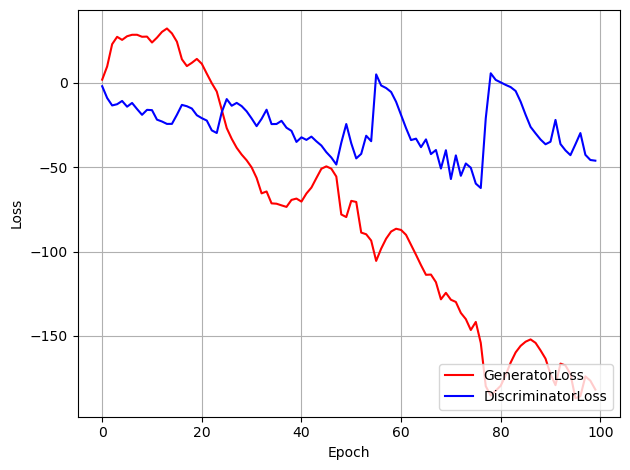

In [8]:
wgan.train()